<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание 4. <br> Логистическая регрессия, метод ближайших соседей и дерево решений на наборе данных UCI Adult

In [20]:
!pip install tqdm

In [36]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm # pip install tqdm – замер времени выполнения итераций цикла
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Визуальный анализ данных

**Считаем [данные](https://archive.ics.uci.edu/ml/datasets/Adult) по жителям США из репозитория UCI. По ссылке можно почитать про данные и смысл признаков.**

In [22]:
adult = pd.read_csv('../../data/adult.data.csv')

In [23]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


**Поисследуйте данные – постройте гистораммы, диаграммы рассеяния с помощью seaborn, посмотрите, как целевой признак salary зависит от других. Используйте методы distplot, pairplot, countplot, boxplot из seaborn (может, и другие). Эта часть задания строго не формулируется.**

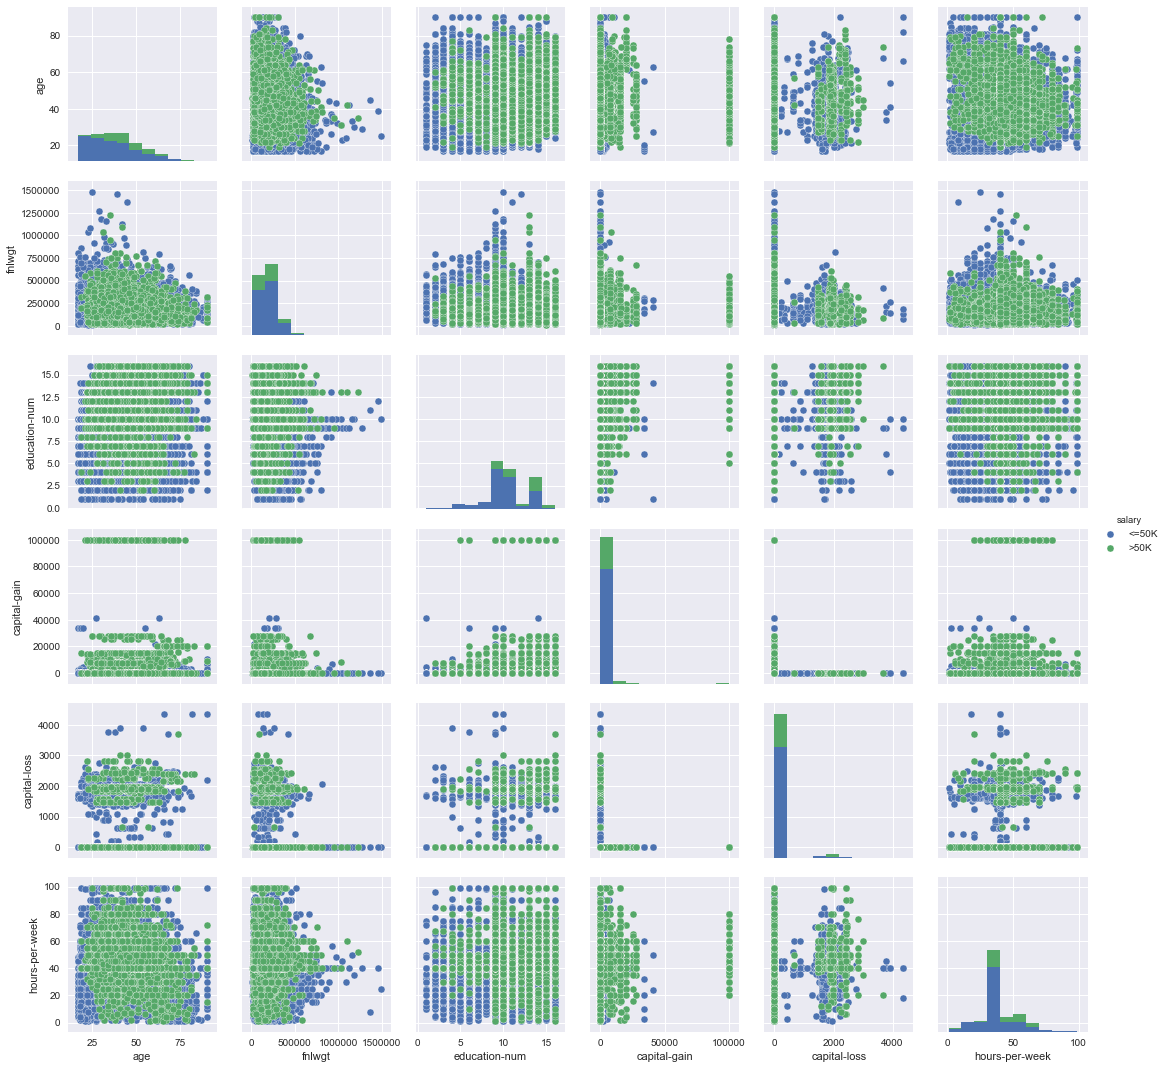

In [60]:
sns.pairplot(adult, hue='salary');

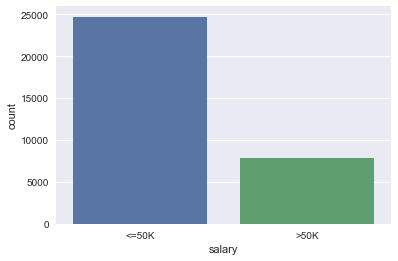

In [61]:
sns.countplot(adult['salary']);

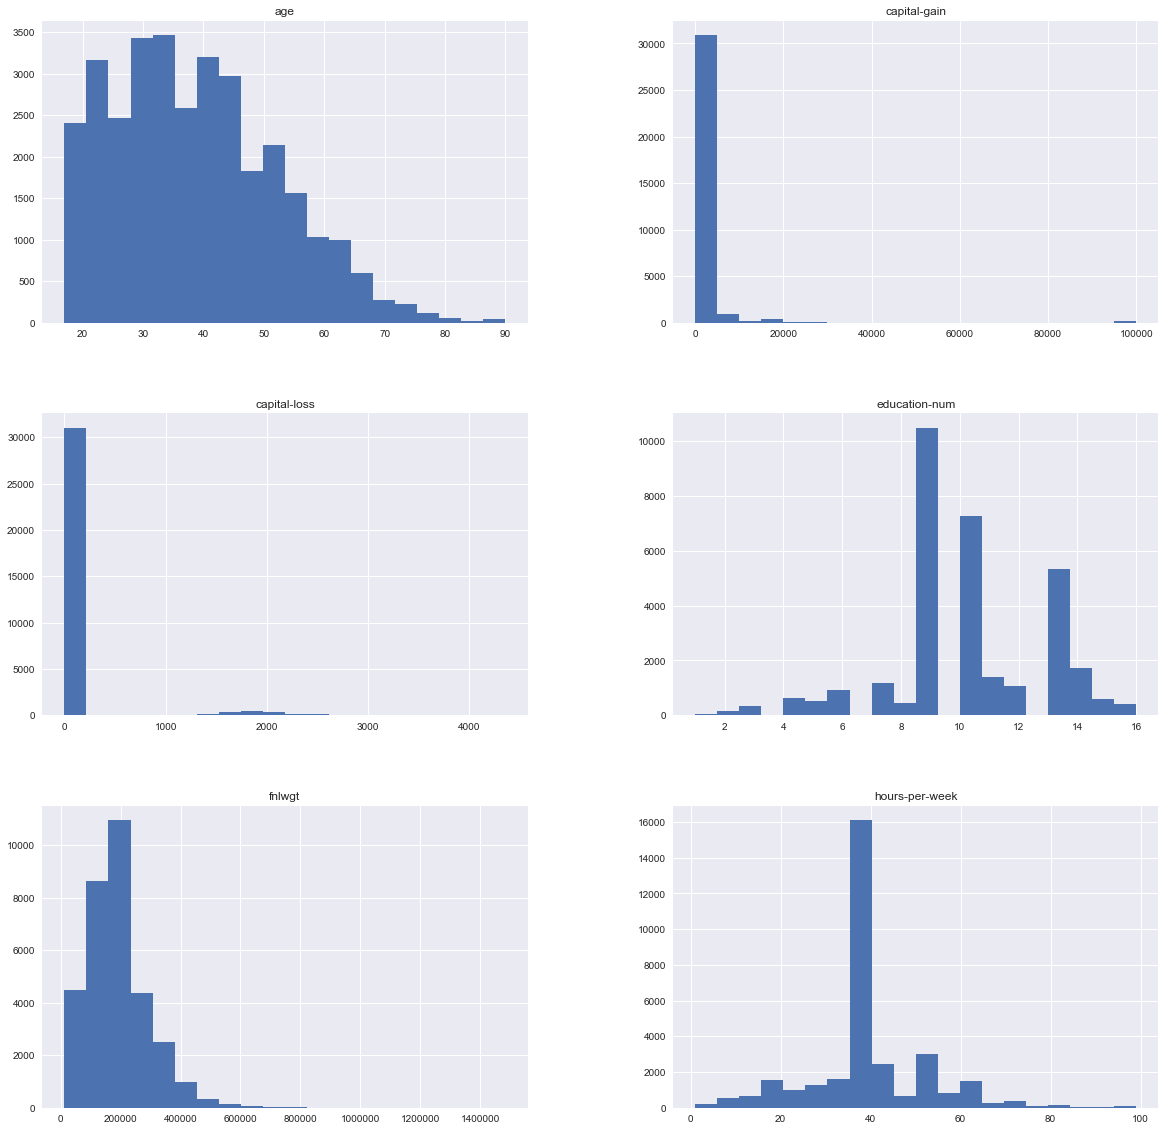

In [62]:
figsize(20, 20)
predictors = list(set(adult.columns))
plots = adult[predictors].hist(bins=20)

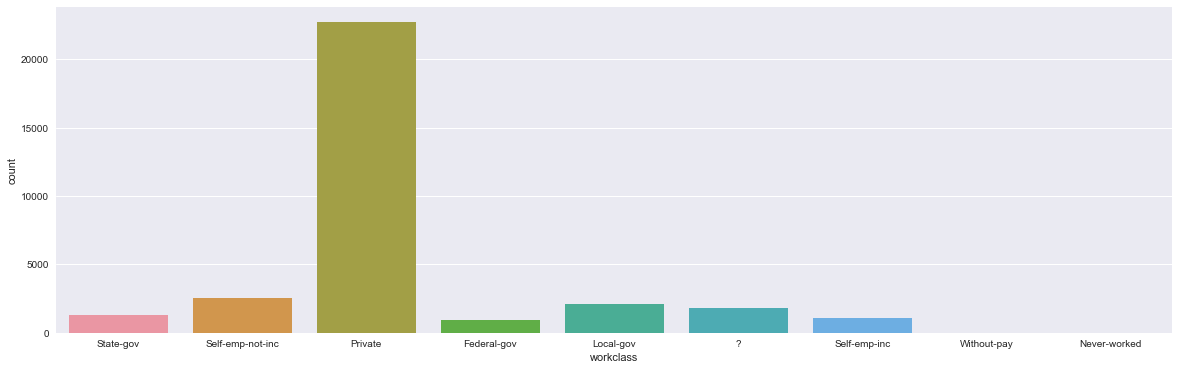

In [72]:
figsize(20, 6)
sns.countplot(adult['workclass']);

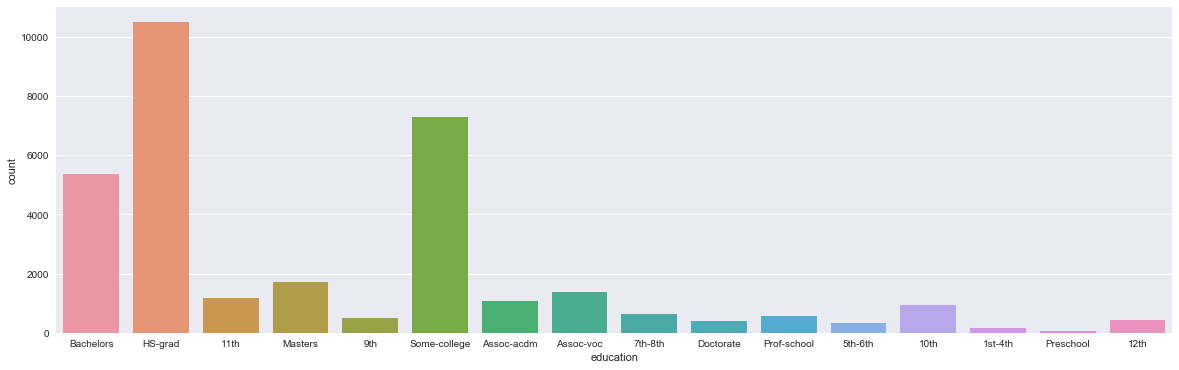

In [73]:
sns.countplot(adult['education']);

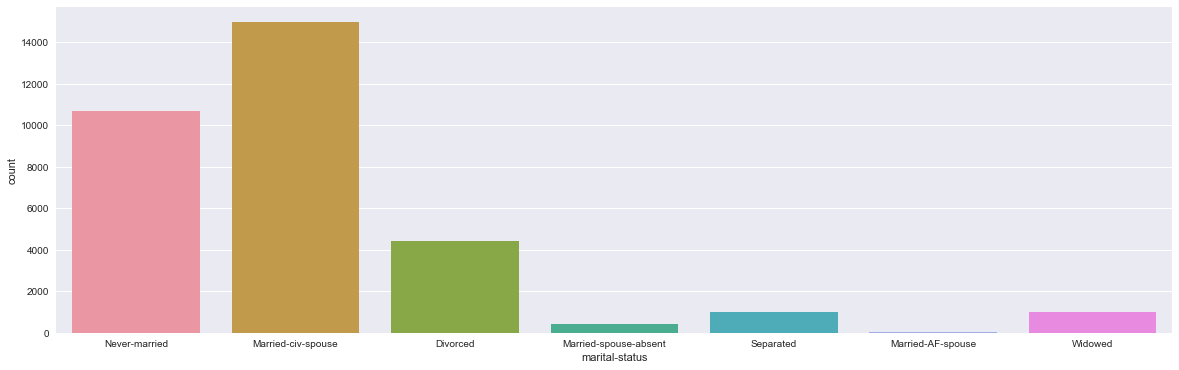

In [74]:
sns.countplot(adult['marital-status']);

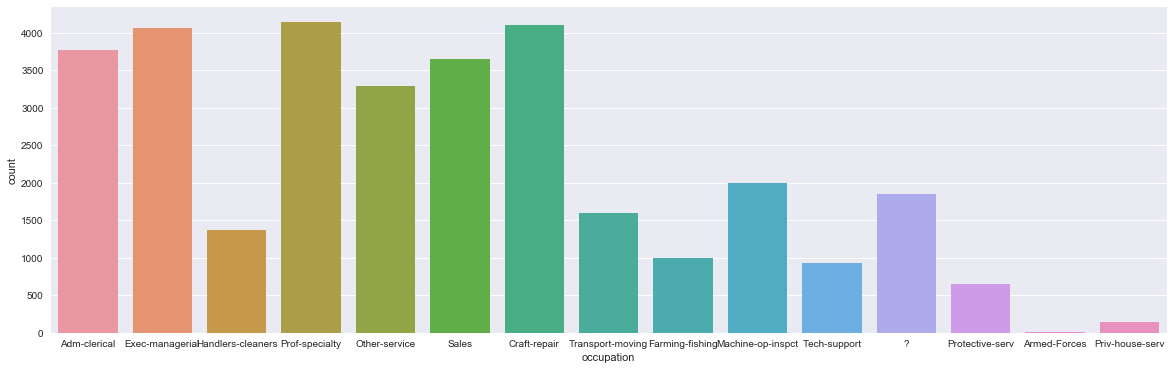

In [75]:
sns.countplot(adult['occupation']);

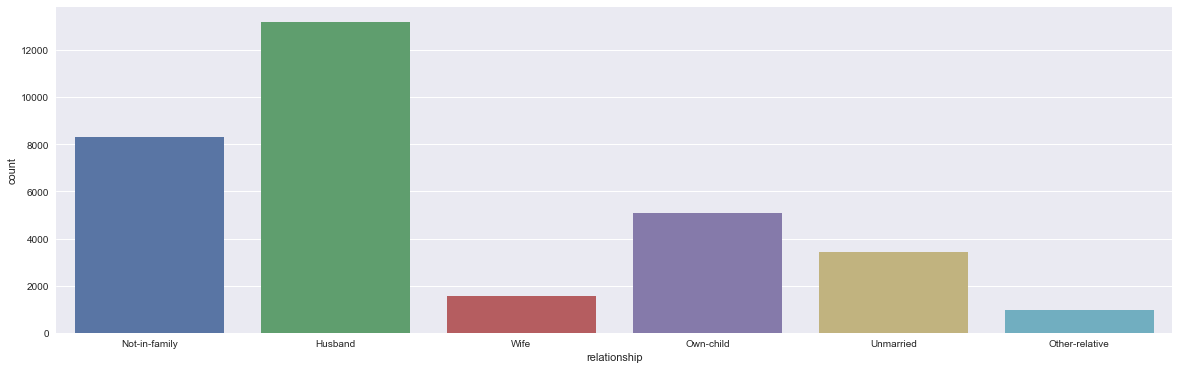

In [76]:
sns.countplot(adult['relationship']);

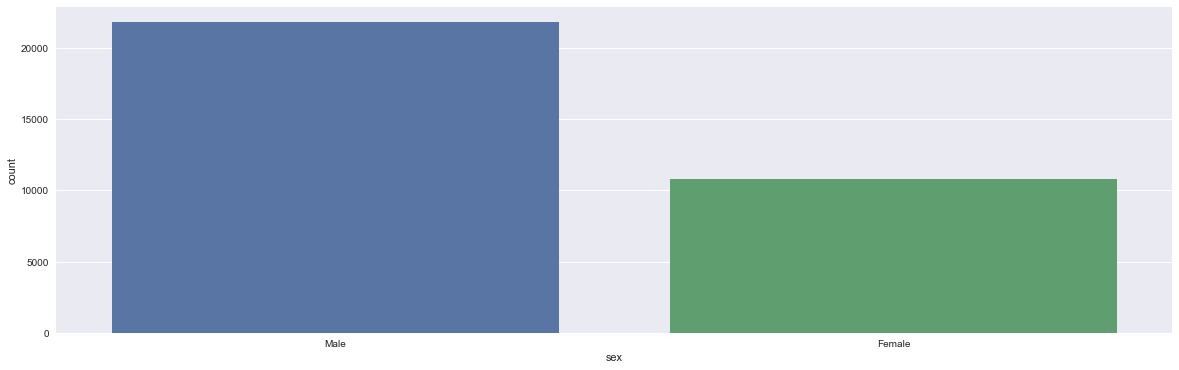

In [77]:
sns.countplot(adult['sex']);

## Часть 2. Подготовка данных

**Выделите целевой признак *y*, равный 1, если зарплата > 50K ($50 тыс. в год) и 0 – иначе.**

In [25]:
y = (adult['salary'] == '>50K').astype('int')

**Составьте DataFrame *X* из количественных признаков – *age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week*.**

In [26]:
X = adult[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]

**Разбейте *X* и *y* на обучающую и проверочную части в отношении 7:3 с помощью метода *train_test_split* из *sklearn.model_selection*. Поскольку разбиение случайно, зафиксируйте параметр *random_state=17* – для воспроизводимости результатов. При необходимости посмотрите встроенную документацию метода.**

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 17)

**Метрические (ex. kNN) и линейные методы (ex. logit) классификации и регрессии чувствительны к диапазону изменения значений признаков и работают лучше, если отмасштабировать признаки – для каждого признака вычесть среднее значение признака и поделить на стандартное отклонение. Это делает класс *StandartScaler* из *sklearn.preprocessing*.**

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## Часть 3. Обучение моделей с параметрами по умолчанию

**Обучите логистическую регрессию с настройками по умолчанию (единственное, укажите *random_state=17*) на тренировочной части выборки *(X_train, y_train)*, сделайте прогнозы для проверочной части *(X_valid, y_valid)*, посчитайте долю правильных ответов (*accuracy_score* из *sklearn.metrics* или метод *score* у обученной модели) на обеих выборках.**

In [39]:
model = LogisticRegression()
model = model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train)

0.81554931554931553

In [40]:
predicted = model.predict(X_valid_scaled)
accuracy_score(predicted, y_valid)

0.81605077285290206

**<font color='red'>Вопрос 1.</font> Каковы доли правильных ответов логистической регрессии на выборках *(X_train_scaled, y_train)* и *(X_valid_scaled, y_valid)*?**

**Обучите метод ближайших соседей с настройками по умолчанию на тренировочной части выборки *(X_train, y_train)*, сделайте прогнозы для проверочной части *(X_valid, y_valid)*, посчитайте долю правильных ответов (*accuracy_score* из *sklearn.metrics* или метод *score* у обученной модели) на обеих выборках.**

In [44]:
model2 = KNeighborsClassifier()
model2 = model2.fit(X_train_scaled, y_train)
model2.score(X_train_scaled, y_train)

0.8574499824499825

In [45]:
predicted = model2.predict(X_valid_scaled)
accuracy_score(predicted, y_valid)

0.80192445490838371

**<font color='red'>Вопрос 2.</font> Каковы доли правильных ответов метода ближайших соседей на выборках *(X_train_scaled, y_train)* и *(X_valid_scaled, y_valid)*?**

**Обучите дерево решений с настройками по умолчанию на тренировочной части выборки *(X_train, y_train)*, сделайте прогнозы для проверочной части *(X_valid, y_valid)*, посчитайте долю правильных ответов (*accuracy_score* из *sklearn.metrics* или метод *score* у обученной модели) на обеих выборках.**

In [48]:
model3 = DecisionTreeClassifier()
model3 = model3.fit(X_train_scaled, y_train)
model3.score(X_train_scaled, y_train)

0.99938574938574942

In [49]:
predicted = model3.predict(X_valid_scaled)
accuracy_score(predicted, y_valid)

0.77182925580919237

**<font color='red'>Вопрос 3.</font> Каковы доли правильных ответов дерева решений на выборках *(X_train_scaled, y_train)* и *(X_valid_scaled, y_valid)*?**

**<font color='red'>Вопрос 4.</font> Почему у дерева решений такая разница между двумя величинами в Вопросе 3?**

## Часть 4. Настройка параметров моделей

**Посмотрите, как качество классификации на обеих выборках зависит у логистической модели от параметра регуляризации *C* (про регуляризацию – далее в курсе). Параметр будем перебирать от 0.001 до 1, 50 значений. Доли правильных ответов на обучающей выборке *(X_train_scaled, y_train)* будем хранить в списке *logit_train_scores*, на проверочной *(X_valid_scaled, y_valid)* – в списке *logit_valid_scores*. Используйте *random_state*=17.**

In [50]:
logit_train_scores, logit_valid_scores = [], []
c_values = np.linspace(1e-3, 1, 50)
for c_val in tqdm(c_values):
    logit = LogisticRegression(C=c_val)
    logit.fit(X_train_scaled, y_train)
    logit_train_scores.append(logit.score(X_train_scaled, y_train))
    logit_valid_scores.append(logit.score(X_valid_scaled, y_valid))

100%|██████████████████████████████████████████| 50/50 [00:04<00:00, 11.94it/s]


**Нарисуем график, как доли правильных ответов зависят от параметра *C* на обеих выборках.**

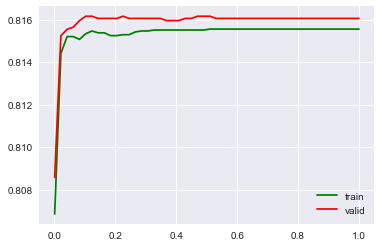

In [51]:
plot(c_values, logit_train_scores, color='green', label='train')
plot(c_values, logit_valid_scores, color='red', label='valid')
legend();

**<font color='red'>Вопрос 5.</font> Каким получилось лучшее значение доли правильных ответов для логистической регрессии на выборке *(X_valid_scaled, y_valid)*? При каком значении параметра *C* оно достигается?**

**Посмотрите, как качество классификации на обеих выборках зависит у метода ближайших соседей от параметра n_neighbors – числа соседей. Параметр будем перебирать от 5 до 140 с шагом 15. Доли правильных ответов на обучающей выборке *(X_train_scaled, y_train)* будем хранить в списке *knn_train_scores*, на проверочной *(X_valid_scaled, y_valid)* – в списке *knn_valid_scores*.**

In [54]:
knn_train_scores, knn_valid_scores = [], []
n_neighbors = np.arange(5, 145, 15)
for n_neighb in tqdm(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors = n_neighb)
    knn.fit(X_train_scaled, y_train)
    knn_train_scores.append(knn.score(X_train_scaled, y_train))
    knn_valid_scores.append(knn.score(X_valid_scaled, y_valid))

100%|██████████████████████████████████████████| 10/10 [01:21<00:00,  9.64s/it]


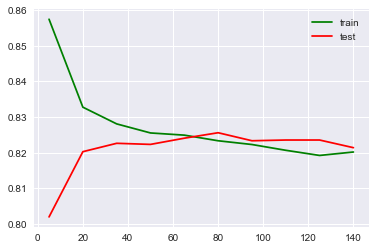

In [55]:
plot(n_neighbors, knn_train_scores, color='green', label='train')
plot(n_neighbors, knn_valid_scores, color='red', label='test')
legend();

**<font color='red'>Вопрос 6.</font> Каким получилось лучшее значение доли правильных ответов для метода ближайших соседей на выборке  *(X_valid_scaled, y_valid)*? При каком значении параметра *n_neighbors* оно достигается?**

**Посмотрите, как качество классификации на обеих выборках зависит у дерева решений от параметра – глубины дерева *max_depth*. Параметр будем перебирать от 2 до 11 –  10 значений. Доли правильных ответов на обучающей выборке *(X_train_scaled, y_train)* будем хранить в списке *tree_train_scores*, на проверочной *(X_valid_scaled, y_valid)* – в списке *tree_valid_scores*. Используйте *random_state*=17.**

In [56]:
tree_train_scores, tree_valid_scores = [], []
depths = np.arange(2,12)
for depth in tqdm(depths):
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train_scaled, y_train)
    tree_train_scores.append(tree.score(X_train_scaled, y_train))
    tree_valid_scores.append(tree.score(X_valid_scaled, y_valid))

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


**Нарисуем график, как доли правильных ответов зависят от параметра *max_depth* на обеих выборках.**

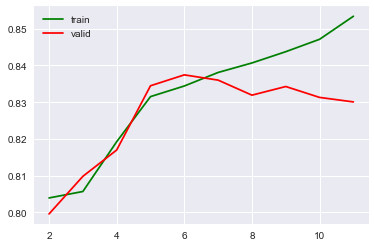

In [57]:
plot(depths, tree_train_scores, color='green', label='train')
plot(depths, tree_valid_scores, color='red', label='valid')
legend();

**<font color='red'>Вопрос 7.</font> Каким получилось лучшее значение доли правильных ответов для дерева решений на выборке  *(X_valid_scaled, y_valid)*? При каком значении параметра *max_depth* оно достигается?**